In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from diffusion import DiffusionModel
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model import AEDist

In [2]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'y0e7txyg'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]

# run_id = 'xdhzzu52'
run_id = 'o19ewxoc'
run = [run for run in sweep.runs if run.id == run_id][0]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [3]:
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]

In [4]:
cfg.layer_widths

[64, 128, 256]

In [5]:
diffusionmodel = DiffusionModel.load_from_checkpoint(
    checkpoint_path=ckpt_path,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [6]:
diffusionmodel.network

MLP(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [7]:
dat = np.load('../dm_data/eb_all_new_2.npz')

In [8]:
dat['data'].shape

(3000, 2)

In [9]:
# data_pred = x_pred[~train_mask]
# latent_pred = z_pred[~train_mask]
train_mask = dat['train_mask']
with torch.no_grad():
    generated_latent = diffusionmodel.generate_samples((~train_mask).sum())

In [10]:
generated_latent.shape

torch.Size([600, 2])

In [11]:
data_latent = np.load(cfg.path + cfg.data)
data_latent_train = data_latent['data'][data_latent['train_mask']]
mean_, std_ = np.mean(data_latent_train, axis=0), np.std(data_latent_train, axis=0)

In [12]:
mean_

array([11.171183 ,  1.5771902], dtype=float32)

In [13]:
std_

array([31.725292, 43.453773], dtype=float32)

In [14]:
generated_latent.size()

torch.Size([600, 2])

In [15]:
generated_latent = generated_latent * std_ + mean_

In [16]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [17]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
latent_gen = generated_latent.detach().cpu().numpy()
latent_test = data_latent['data'][~data_latent['train_mask']]
latent_train = data_latent['data'][data_latent['train_mask']]

In [19]:
def compute_w2(gen, tru):
    M = ot.dist(gen, tru)
    M = torch.tensor(M, dtype=torch.float32, device=device)
    # M/=M.max()
    n = latent_test.shape[0]
    a, b = torch.ones((n,)).to(device) / n, torch.ones((n,)).to(device) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)
    W = torch.sum(G0 * M)
    return torch.sqrt(W)

In [20]:
std = latent_train.std()
noises = np.arange(1, 10) * 0.1
w2s = []
for noise in noises:
    noisy_test = latent_test + np.random.randn(*latent_test.shape) * noise * std
    w2 = compute_w2(noisy_test, latent_test).detach().cpu().numpy()
    w2s.append(w2)

In [21]:
mean = latent_train.mean(axis=0)
cov = np.cov(latent_train, rowvar=False)
rand_samples = np.random.multivariate_normal(mean, cov, latent_test.shape[0])

In [22]:
res = np.array([noises, w2s]).T
w_rand = compute_w2(rand_samples, latent_test).cpu().numpy()
w_gen = compute_w2(latent_gen, latent_test).cpu().numpy()

In [23]:
np.random.seed(42)
latent_train_subset_id = np.random.choice(np.arange(len(latent_train)), size=len(latent_test), replace=False)
latent_train_subset = latent_train[latent_train_subset_id]
w_train = compute_w2(latent_train_subset, latent_test).cpu().numpy()

Text(0, 0.5, 'w2')

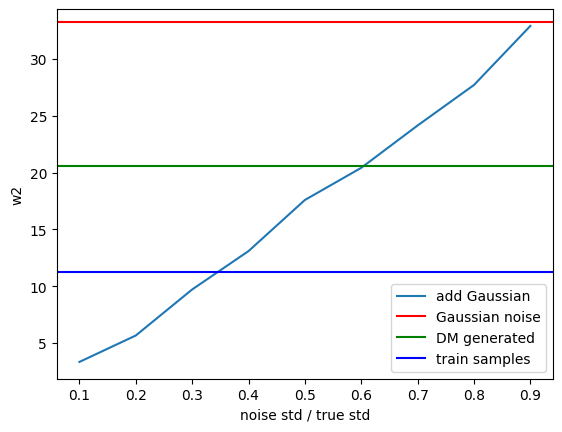

In [24]:
fig, ax = plt.subplots()
ax.plot(res[:,0], res[:,1], label='add Gaussian')
ax.axhline(y=w_rand, color='r', linestyle='-', label='Gaussian noise')
ax.axhline(y=w_gen, color='g', linestyle='-', label='DM generated')
ax.axhline(y=w_train, color='b', linestyle='-', label='train samples')
# ax.axhline(y=w_permu, color='y', linestyle='-', label='permuted samples')
ax.legend()
ax.set_xlabel('noise std / true std')
ax.set_ylabel('w2')

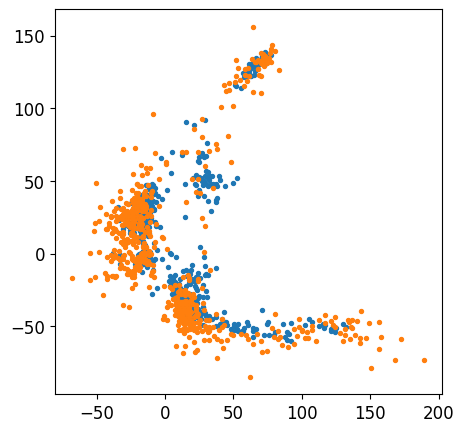

In [25]:
# make two subplots side by side
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
scprep.plot.scatter2d(latent_test, ax=axes)
scprep.plot.scatter2d(generated_latent.cpu().numpy(), ax=axes)
plt.show()

In [26]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = '9qr8zqxg'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]
run_id = 'guesg5ug'
run = [run for run in sweep.runs if run.id == run_id][0]
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path, allow_pickle=True)
# model = AEDist(dim=50, emb_dim=10)
# model.load_from_checkpoint(ckpt_path)
model = AEDist.load_from_checkpoint(ckpt_path)
model.eval()
# x_all = torch.tensor(data['data'], dtype=torch.float32)
# x_pred, z_pred = model(x_all)
# x_pred = x_pred.detach().cpu().numpy()
# z_pred = z_pred.detach().cpu().numpy()

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

AEDist(
  (encoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [27]:
gen_decoded = model.decode(generated_latent)

In [28]:
gen_decoded.shape

torch.Size([600, 50])

In [29]:
test_ambient = data['data'][~data['is_train']]
test_ambient = torch.tensor(test_ambient, dtype=torch.float)
train_ambient = data['data'][data['is_train']]
train_ambient = torch.tensor(train_ambient, dtype=torch.float)

In [30]:
w_gen = compute_w2(gen_decoded, test_ambient)

/tmp/tmp.g8foCrPrcR/ipykernel_3596403/1789824827.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M, dtype=torch.float32, device=device)


In [31]:
std = train_ambient.std()
noises = np.arange(1, 10) * 0.1
w2s = []
for noise in noises:
    noisy_test = test_ambient + torch.tensor(np.random.randn(*test_ambient.shape), dtype=torch.float32) * noise * std
    w2 = compute_w2(noisy_test, test_ambient).detach().cpu().numpy()
    w2s.append(w2)
res = np.array([noises, w2s]).T

mean = train_ambient.mean(axis=0)
cov = np.cov(train_ambient, rowvar=False)
rand_samples = np.random.multivariate_normal(mean, cov, test_ambient.shape[0])
rand_samples = torch.tensor(rand_samples, dtype=torch.float32)
w_rand = compute_w2(rand_samples, test_ambient).cpu().numpy()

np.random.seed(42)
train_ambient_subset_id = np.random.choice(np.arange(len(train_ambient)), size=len(test_ambient), replace=False)
train_ambient_subset = train_ambient[train_ambient_subset_id]
w_train = compute_w2(train_ambient_subset, test_ambient).cpu().numpy()



/tmp/tmp.g8foCrPrcR/ipykernel_3596403/1789824827.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M, dtype=torch.float32, device=device)


Text(0, 0.5, 'w2')

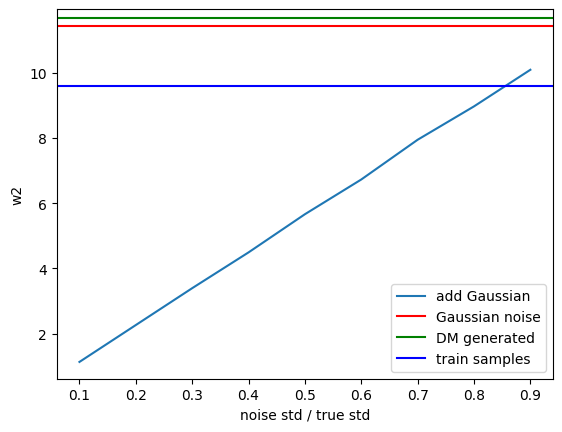

In [32]:
fig, ax = plt.subplots()
ax.plot(res[:,0], res[:,1], label='add Gaussian')
ax.axhline(y=w_rand, color='r', linestyle='-', label='Gaussian noise')
ax.axhline(y=w_gen.cpu().numpy(), color='g', linestyle='-', label='DM generated')
ax.axhline(y=w_train, color='b', linestyle='-', label='train samples')
# ax.axhline(y=w_permu.cpu().numpy(), color='y', linestyle='-', label='permuted samples')
ax.legend()
ax.set_xlabel('noise std / true std')
ax.set_ylabel('w2')

In [33]:
pc_data = np.load('../data/eb_all_pcs_correct.npz')